# Neural Processes

This implementation is based on [EmilienDupont/neural-processes]((https://github.com/EmilienDupont/neural-processes)).

## Overview of files

- **neuralprocess.py** contains 
  - *NeuralProcess()* model class and the following functions:
    - *__init__()* - Initialisies all three coders
      - *self.xy_to_r* - rEncoder
      - *self.r_to_mu_sigma* - zEncoder
      - *self.xz_to_y* - Decoder
    - *aggregate()* - Mean aggregation, permutation invariance
    - *xy_to_mu_sigm()* - Encoding via rEncoder and zEncoder
    - *forward()* - full forward pass
      - *training mode* - uses target encoding for z?!
      - *testing mode*  

  - *NeuralProcess2D()* wrapping calling on *NeuralProcess()*
    - mask_to_np_input()
  

- **coders.py** contains all three coders
  - *rEncoder()* - 2-layer (2 hidden layers) MLP with ReLu activation functions. Last layer without activation.
  - *zEncoder()* - 1-layer (1 hidden layer) MLP with ReLu activation function mapping r_agg to z parameters. Sigma is defined using 0.1 + 0.9 * sigmoid() (latent variance clipping to [0.1, 1]). 
  - *Decoder()* - 3-layer (3 hidden layers) MLP with ReLu activation functions. Sigma is defined using 0.1 + 0.9 * softplus() (thus unbounded).

- **utisl.py** contains helper functions:
  - *context_target_split()* - samples x_target, y_target and their subsets x_context and x_target.
  - *mask_to_np_input()*

- **datasets.py**
  - *SineData()* is a class
  - *SineDisconData()* is a class
  - *mnist()* is a function that returns dataloader objects for test and train

-  **training.py** contains *NeuralProcessTrainer()* class and the following functions:
   - *loss()* Log-likelihood of y_predcitions and ELBO term (KL divergence of q_targets/q_context)
   - backpropagation possible due to reparametrisation trick.


## Implementation recommendations: 

- [Le, Tuan Anh, et al. "Empirical evaluation of neural process objectives." NeurIPS workshop on Bayesian Deep Learning. Vol. 4. 2018.](http://bayesiandeeplearning.org/2018/papers/92.pdf)
  - context size m and target size n (superset) with m < n.
  - activation on scale output of encoder and decoder.


## ToDos
- represenation aggregation over batches or full task?
- target and context modes during training and testing
- expressivity of variance under decoder implementation
  - visualise co-varaicne function
- increase batch size in examples
- understand comment about fixed observation variance (in Garnelo)
  - add observation noise
- visualise loss
- Vary number of contexts

- variance is still too large

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
import sys
import os
print(sys.path)


['/Users/kimbente/NeuralProcesses', '/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python39.zip', '/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9', '/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/lib-dynload', '', '/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages']


### Visualize Sine Data

/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <67CD63CE-57E0-341F-B3B8-78729B03D2B3> /Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <18497461-1393-3DF8-BED0-DC986FDB1051> /Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


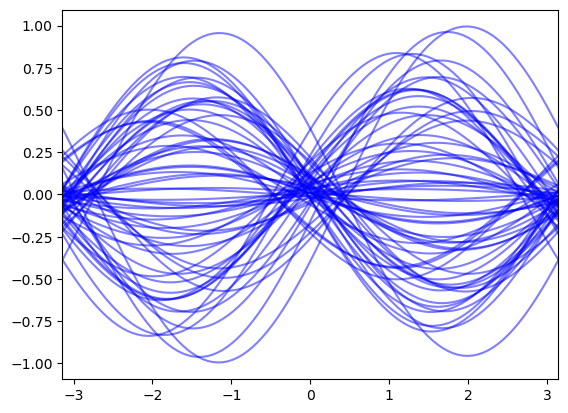

In [5]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range = (-1, 1), # amplitude_range = (1, 1)
                   shift_range = (-0.5, 0.5), # shift_range = (-.5, .5) shift_range = (0, 0)
                   num_samples = 2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c = 'b', alpha = 0.5)
    plt.xlim(-pi, pi)

## Visualize SineDiscontionous Data

$$ \text{for } x < bp: \\
 f(x) = a * sin(x - b)
$$

$$ \text{for } x \geq bp: \\
 f(x) = a * sin(x - b) + c
$$

$$ \text{with } \\
a\text{: amplitude scalar sampled uniformly from }(0.5, 1.)\\
b\text{: horizontal shift sampled uniformly from }(-0.5, 0.5)\\
c\text{: vertical shift sampled uniformly from }(0, 1)\\
bp\text{: breakpoint fixed to }(0).
$$

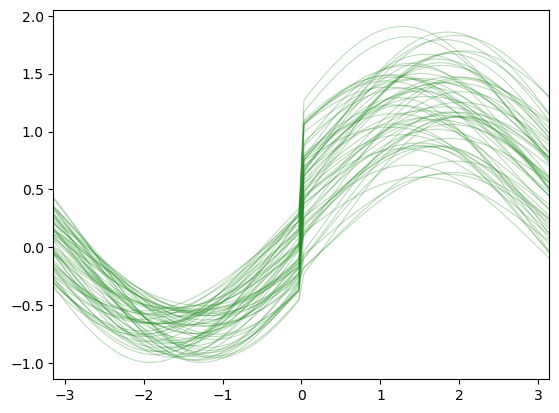

In [6]:
from math import pi
from datasets import SineDiscontData

dataset = SineDiscontData(num_samples = 2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c = 'forestgreen', alpha = 0.3, linewidth = '.8' )
    plt.xlim(-pi, pi)

### Build Neural Process

In [7]:
from neuralprocess import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

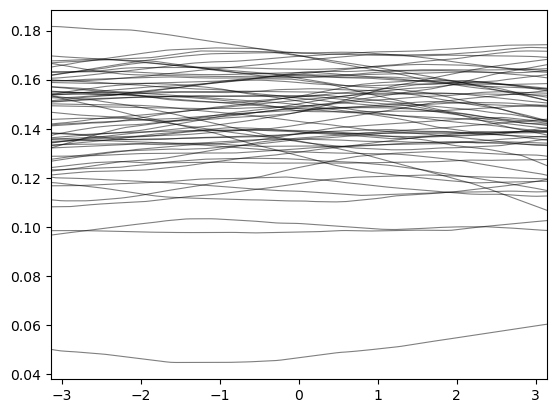

In [8]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c = 'black', alpha = 0.5, linewidth = '.8')
    plt.xlim(-pi, pi)

### Train Neural Process

In [9]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 4 # increase
num_context = 4
num_target = 4 # extra targets

data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr = 3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range = (num_context, num_context),
                                  num_extra_target_range = (num_target, num_target), 
                                  print_freq = 200)

# Training mode
neuralprocess.training = True
np_trainer.train(data_loader, epochs = 60)

iteration 200, loss 5.653
iteration 400, loss 7.512
Epoch: 0, average loss: 5.72
iteration 600, loss 4.274
iteration 800, loss 2.066
iteration 1000, loss 1.033
Epoch: 1, average loss: 2.156
iteration 1200, loss 1.578
iteration 1400, loss -0.572
Epoch: 2, average loss: 0.726
iteration 1600, loss -0.853
iteration 1800, loss -0.713
iteration 2000, loss -0.222
Epoch: 3, average loss: 0.402
iteration 2200, loss -2.346
iteration 2400, loss 1.962
Epoch: 4, average loss: -0.05
iteration 2600, loss 0.876
iteration 2800, loss -1.338
iteration 3000, loss -1.631
Epoch: 5, average loss: -0.284
iteration 3200, loss -0.018
iteration 3400, loss -1.525
Epoch: 6, average loss: -0.368
iteration 3600, loss -1.329
iteration 3800, loss -0.931
iteration 4000, loss -0.782
Epoch: 7, average loss: -0.367
iteration 4200, loss -0.785
iteration 4400, loss -1.339
Epoch: 8, average loss: -0.566
iteration 4600, loss 1.088
iteration 4800, loss -3.005
iteration 5000, loss -2.255
Epoch: 9, average loss: -0.77
iteration 

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

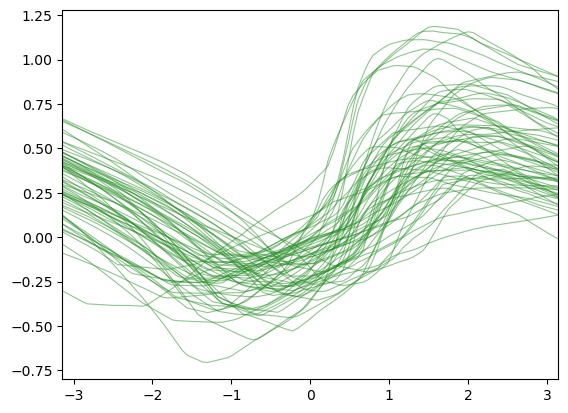

In [10]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c = 'forestgreen', alpha = 0.5, linewidth = "0.8")
    plt.xlim(-pi, pi)

### Visualize samples from posterior

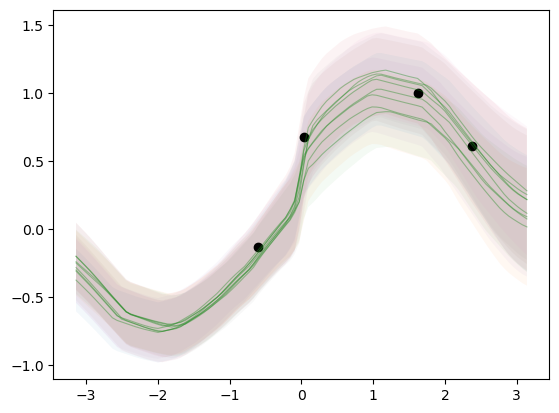

In [11]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

# showing 8
for i in range(8):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha = 0.4, c = 'forestgreen', linewidth = '0.8')
    plt.fill_between(x = x_target.numpy()[0].squeeze(), 
                     y1 = (mu.numpy()[0] - 2 * sigma.numpy()[0]).squeeze(), 
                     y2 = (mu.numpy()[0] + 2 * sigma.numpy()[0]).squeeze(),
             alpha = 0.05,)

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

- currently still underfitting a little bit to the context points

## Experiment 2

Change parameters

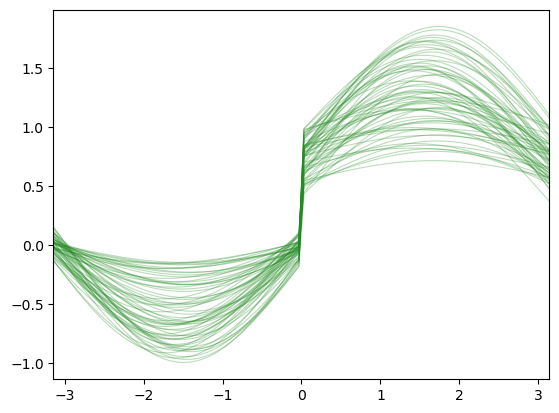

In [12]:
dataset2 = SineDiscontData(num_samples = 2000, amplitude_range = (0.1, 1.), 
                          horizontal_shift_range = (-.2, .2), 
                          vertical_shift_range = (0.5, 1))

# Visualize data samples
for i in range(64):
    x, y = dataset2[i] 
    plt.plot(x.numpy(), y.numpy(), c = 'forestgreen', alpha = 0.3, linewidth = '.8' )
    plt.xlim(-pi, pi)

In [13]:
from neuralprocess import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 128  # Dimension of representation of context points
z_dim = 128  # Dimension of sampled latent variable
h_dim = 64  # Dimension of hidden layers in encoder and decoder

neuralprocess2 = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

In [14]:
batch_size = 2
num_context = 4
num_target = 4 # extra targets

data_loader2 = DataLoader(dataset2, batch_size = batch_size, shuffle = True)
optimizer2 = torch.optim.Adam(neuralprocess2.parameters(), lr = 3e-4)
np_trainer2 = NeuralProcessTrainer(device, neuralprocess2, optimizer2,
                                  num_context_range = (num_context, num_context),
                                  num_extra_target_range = (num_target, num_target), 
                                  print_freq = 200)

# Trainind mode
neuralprocess2.training = True
np_trainer2.train(data_loader2, epochs = 90)
# Originally it was 30

iteration 200, loss 6.011
iteration 400, loss 4.227
iteration 600, loss 1.131
iteration 800, loss -1.771
iteration 1000, loss 4.427
Epoch: 0, average loss: 3.679
iteration 1200, loss 1.557
iteration 1400, loss -1.064
iteration 1600, loss -2.706
iteration 1800, loss -0.433
iteration 2000, loss -4.705
Epoch: 1, average loss: -1.146
iteration 2200, loss -1.731
iteration 2400, loss -2.909
iteration 2600, loss 5.345
iteration 2800, loss 1.889
iteration 3000, loss -4.787
Epoch: 2, average loss: -2.023
iteration 3200, loss -4.071
iteration 3400, loss -0.310
iteration 3600, loss -0.140
iteration 3800, loss -2.997
iteration 4000, loss 3.383
Epoch: 3, average loss: -2.878
iteration 4200, loss -6.014
iteration 4400, loss -1.990
iteration 4600, loss -2.371
iteration 4800, loss -1.776
iteration 5000, loss -5.806
Epoch: 4, average loss: -3.468
iteration 5200, loss -5.358
iteration 5400, loss -3.352
iteration 5600, loss -6.550
iteration 5800, loss -5.323
iteration 6000, loss -7.698
Epoch: 5, average 

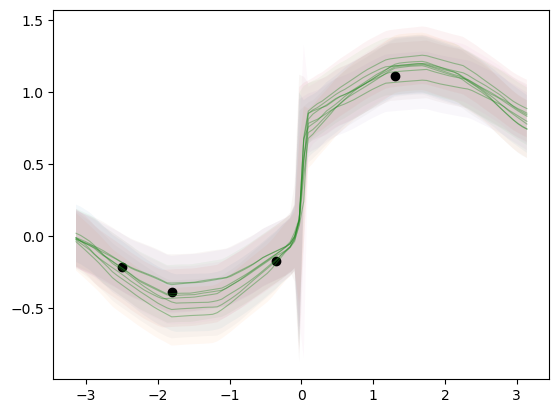

In [149]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader2:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess2.training = False

# showing 8
for i in range(8):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess2(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha = 0.4, c = 'forestgreen', linewidth = '0.8')
    plt.fill_between(x = x_target.numpy()[0].squeeze(), 
                     y1 = (mu.numpy()[0] - 2 * sigma.numpy()[0]).squeeze(), 
                     y2 = (mu.numpy()[0] + 2 * sigma.numpy()[0]).squeeze(),
             alpha = 0.05,)

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')